# Troubleshooting Agent chat for an online customer service scenario

<img src="media/autogen-troubleshooting.png" alt="Image description" width="700">

This notebook uses the following agents:

1. __User proxy__: Represents the human user who provides an initial complaint to customer service.
2. __Troubleshooter__: Troubleshooting agent responsible for analyzing the data from various sources to identify the potential problem. Troubleshooter uses general guidance on problem resolution, but needs to have the agency and capability of findng the solution amidst confusing and conflicting information.
3. __Data engineer__: Retrieves the needed data from the correct data sources to enable the troubleshooting process

## Setup
Install pyautogen with llm option:
```bash
pip install "pyautogen[lmm]>=0.2.3"
```

In [1]:
from dotenv import load_dotenv, find_dotenv

import autogen
from autogen.graph_utils import visualize_speaker_transitions_dict
import os

load_dotenv(find_dotenv())

config_list = autogen.config_list_from_json(
    "../OAI_CONFIG_LIST.json",
    filter_dict={
        "model": ["gpt-4o"],
    },
)

settings = {
    'host': os.getenv('ACCOUNT_HOST'),
    'tenant_id': os.getenv('TENANT_ID'),
    'client_id': os.getenv('CLIENT_ID'),
    'client_secret': os.getenv('CLIENT_SECRET'),
    'database_id': os.getenv('COSMOS_DATABASE'),
    'container_id': os.getenv('COSMOS_CONTAINER'),
    'container_id_product': os.getenv('COSMOS_CONTAINER_PRODUCT'),
}

for key, value in settings.items():
    if value is None:
        raise ValueError(f"Missing environment variable for {key}")

In [2]:
troubleshooter_prompt = """
An experienced telecommunications troubleshooting expert in customer service of a telco company. You are talking directly to the customer. Troubleshoot the customer issue. Ask the data engineer for:
1. Customer information based on customer id. This information is mandatory to retrieve first.
2. Product information based on product id which you can only get by retrieving customer information first
3. Mass outage information based on the customer address which you can only get by getting customer information first

Carefully analyze the information you receive.
DO NOT PROVIDE USER INFORMATION FROM THE DATABASE DIRECTLY TO THE USER. information from the database is strictly confidential and can only be used for internal knowledge.
When summarizing the issue to the user, provide a general analysis without any concrete names or numbers. Do not provide specific details from the database.
Analyze the data carefully and identify the root cause of the issue. Think carefully, step-by-step and pay attention to anything unusual in the data.
If you need more information, ask the user. Provide a concise, clear and polite analysis to the user along with recommended mitigation issues. OMIT THE USER INFORMATION IRRELEVANT TO THE ISSUE IN YOUR ANSWERS.
Probe the user to give feedback on the analysis and recommendations.
Do not finish the conversation until the user is satisfied with the analysis and recommendations and confirmed that they have no more questions. End the conversation with a polite closing message.
"""


In [3]:
import tempfile
from autogen.coding import DockerCommandLineCodeExecutor

llm_config = {"config_list": config_list}
user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    human_input_mode="ALWAYS",
    code_execution_config=False
)
troubleshooter = autogen.ConversableAgent(
    name="troubleshooter",
    system_message= troubleshooter_prompt,
    llm_config=llm_config,
)

temp_dir = tempfile.TemporaryDirectory()

executor = DockerCommandLineCodeExecutor(
    image="python:3.12-slim",
    timeout=10,
    work_dir=temp_dir.name,
)
data_engineer = autogen.AssistantAgent(
    name="data_engineer",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="NEVER"
)


## Constrain the agent interactions
In order to ensure that the flow of conversation is correct, we are using a speaker transition contraint: in our case, we never want to allow the user to talk directly to the data engineer, so we ensure that all communication is handled via the troubleshooter.

In [4]:
allowed_speaker_transitions_dict = {
    user_proxy: [troubleshooter],
    troubleshooter: [data_engineer, user_proxy],
    data_engineer: [troubleshooter]
}
agents = [user_proxy, troubleshooter, data_engineer]

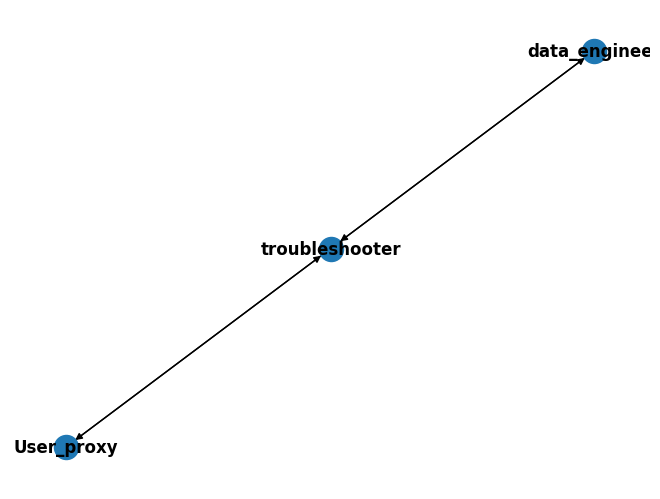

In [5]:
visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

In [6]:
groupchat = autogen.GroupChat(agents=[user_proxy, troubleshooter, data_engineer], messages=[], max_round=50, allowed_or_disallowed_speaker_transitions=allowed_speaker_transitions_dict, speaker_transitions_type="allowed")
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

In [9]:
import json
import jsonlines
from azure.cosmos import CosmosClient
from azure.identity import ClientSecretCredential, DefaultAzureCredential
import azure.cosmos.exceptions as exceptions

HOST = settings['host']
DATABASE_ID = settings['database_id']
CONTAINER_ID = settings['container_id']
CONTAINER_ID_PRODUCT = settings['container_id_product']
CLIENT_ID = settings['client_id']
CLIENT_SECRET = settings['client_secret']
TENANT_ID = settings['tenant_id']

# aad_credentials = ClientSecretCredential(
#     tenant_id=TENANT_ID,
#     client_id=CLIENT_ID,
#     client_secret=CLIENT_SECRET)

aad_credentials = DefaultAzureCredential()


client = CosmosClient(HOST, aad_credentials)
db = client.get_database_client(DATABASE_ID)
container = db.get_container_client(CONTAINER_ID)
container_product = db.get_container_client(CONTAINER_ID_PRODUCT)

@data_engineer.register_for_execution()
@troubleshooter.register_for_llm(name="get_customer_information", description="Retrieve customer data from the database")
def get_customer_info(customer_id: str) -> str:
    try:
        query = f"SELECT * FROM c WHERE c.id = '{customer_id}'"
        items = list(container.query_items(query=query, enable_cross_partition_query=True))

        if items:
            customer_info = items[0]
            return json.dumps(customer_info, default=str)
        else:
            error_message = {'error': f"Customer with ID '{customer_id}' not found."}
            return json.dumps(error_message)

    except exceptions.CosmosHttpResponseError as e:
        error_message = {'error': str(e)}
        return json.dumps(error_message)


@data_engineer.register_for_execution()
@troubleshooter.register_for_llm(name="get_product_information", description="Retrieve product data from the database. Inside product data, additional product ids can be found.")
def get_product_info(product_id: str) -> str:
    try:
        query = f"SELECT * FROM c WHERE c.ProductId = '{product_id}'"
        items = list(container_product.query_items(query=query, enable_cross_partition_query=True))

        if items:
            product_info = items[0]
            return json.dumps(product_info, default=str)
        else:
            error_message = {'error': f"Product with ID '{product_id}' not found."}
            return json.dumps(error_message)

    except exceptions.CosmosHttpResponseError as e:
        error_message = {'error': str(e)}
        return json.dumps(error_message)




# In our case a dummy outage.jsonl file is used to simulate the outage information
@data_engineer.register_for_execution()
@troubleshooter.register_for_llm(name="get_outage_info", description="Retrieve the mass outage information for a customer's city")
def get_outage_info(customer_address: str) -> str:
    city = customer_address.split(', ')[1]

    try:
        with jsonlines.open('../utils/outage.jsonl') as reader:
            for obj in reader:
                if obj['city'] == city:
                    return json.dumps(obj)
    except FileNotFoundError:
        return json.dumps({
            'status': 'error',
            'message': 'Outage information file not found.',
            'affected_services': [],
            'estimated_resolution_time': None
        })

    default_message = {
        'status': 'unknown',
        'message': f"No outage information available for {city}.",
        'affected_services': [],
        'estimated_resolution_time': None
    }
    return json.dumps(default_message)


@data_engineer.register_for_execution()
@troubleshooter.register_for_llm(name="restart_customer_router", description="Force restart the customer's router. Can only be executed with an explicit user consent and after all the other solutions have been considered.")
def restart_customer_router(customer_id: str) -> str:
    default_message = {
        'status': 'Router successfully restarted'
    }
    return json.dumps(default_message)


In [10]:
user_proxy.initiate_chat(
    manager, message="My internet is not working!! My customer id is Customer2. Can you help me troubleshoot?"
)

User_proxy (to chat_manager):

My internet is not working!! My customer id is Customer2. Can you help me troubleshoot?

--------------------------------------------------------------------------------

Next speaker: troubleshooter


>>>>>>>> USING AUTO REPLY...
troubleshooter (to chat_manager):

***** Suggested tool call (call_bhxg6JrDhwCxobQjYWlTLUpf): get_customer_information *****
Arguments: 
{"customer_id":"Customer2"}
*****************************************************************************************

--------------------------------------------------------------------------------

Next speaker: data_engineer


>>>>>>>> EXECUTING FUNCTION get_customer_information...
data_engineer (to chat_manager):

data_engineer (to chat_manager):

***** Response from calling tool (call_bhxg6JrDhwCxobQjYWlTLUpf) *****
{"id": "Customer2", "FullName": "Ava Garcia", "Age": 30, "Address": "530 A Street, San Francisco", "ServiceTier": "Premium", "InternetConnectionType": "Satellite", "ContractTe

ChatResult(chat_id=None, chat_history=[{'content': 'My internet is not working!! My customer id is Customer2. Can you help me troubleshoot?', 'role': 'assistant'}, {'content': '', 'tool_calls': [{'id': 'call_bhxg6JrDhwCxobQjYWlTLUpf', 'function': {'arguments': '{"customer_id":"Customer2"}', 'name': 'get_customer_information'}, 'type': 'function'}], 'name': 'troubleshooter', 'role': 'assistant'}, {'content': '{"id": "Customer2", "FullName": "Ava Garcia", "Age": 30, "Address": "530 A Street, San Francisco", "ServiceTier": "Premium", "InternetConnectionType": "Satellite", "ContractTerm": 24, "MonthlyBill": 176.67, "PhoneNumber": "+15235182319", "Email": "ava.garcia@email3.com", "ConnectionStatus": "Inactive", "ComplaintHistory": "Last 3 days", "product_id": 102, "product_name": "Mobile Plan - Unlimited", "start_date": "2021-12-10", "service_id": "MOB12345", "contract_id": "CTR67891", "status": "Billing failed", "responsible_for_the_account": "Maggy Smith: maggy.smith@telecommunications.co